In [1]:
# Import Library
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import ast



2024-03-21 04:27:54.714220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 04:27:54.714327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 04:27:54.850210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read Dataset
train_path = '/kaggle/input/dataset-asli-2/dataset/train_preprocess.csv'
valid_path = '/kaggle/input/dataset-asli-2/dataset/valid_preprocess.csv'
test_path = '/kaggle/input/dataset-asli-2/dataset/test_preprocess.csv'

df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_test = pd.read_csv(test_path)

In [3]:
# About dataset
df_train.info()
df_valid.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3830 entries, 0 to 3829
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3830 non-null   object
 1   tweet   3830 non-null   object
dtypes: object(2)
memory usage: 60.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   529 non-null    object
 1   tweet   529 non-null    object
dtypes: object(2)
memory usage: 8.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   529 non-null    object
 1   tweet   529 non-null    object
dtypes: object(2)
memory usage: 8.4+ KB


In [4]:
def get_label_counts(df):
    x = df['label'].unique()
    y = df['label'].value_counts()
    return x, y

# Get label counts for each dataframe
train_labels, train_label_counts = get_label_counts(df_train)
valid_labels, valid_label_counts = get_label_counts(df_valid)
test_labels, test_label_counts = get_label_counts(df_test)

# Print label counts
print("Train Label Counts:")
print(train_label_counts)

print("\nValid Label Counts:")
print(valid_label_counts)

print("\nTest Label Counts:")
print(test_label_counts)

Train Label Counts:
label
anger      881
happy      814
sadness    798
fear       519
love       509
disgust    309
Name: count, dtype: int64

Valid Label Counts:
label
anger      110
happy      102
sadness     99
disgust     89
fear        65
love        64
Name: count, dtype: int64

Test Label Counts:
label
anger      110
happy      101
sadness    100
disgust     89
fear        65
love        64
Name: count, dtype: int64


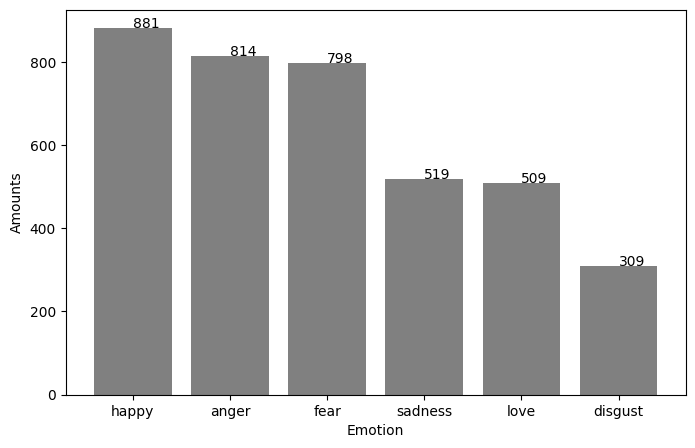

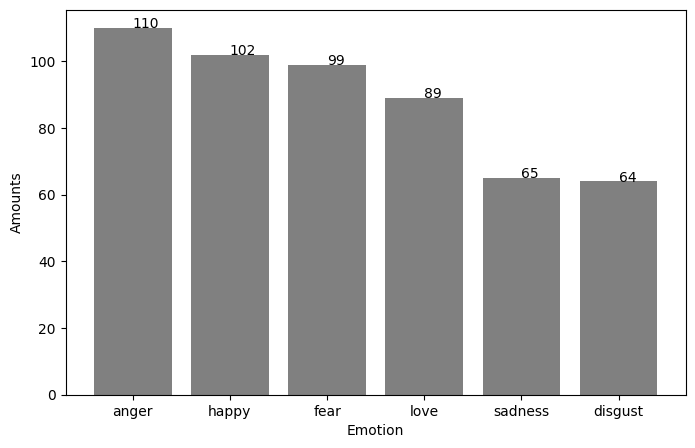

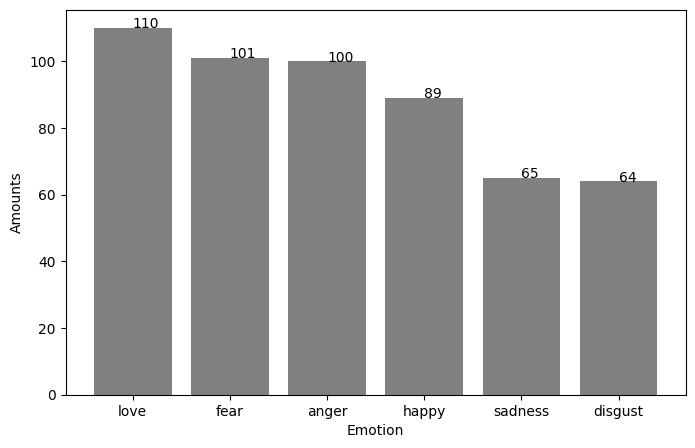

In [5]:
def plot_label_counts(x, y):
    plt.xlabel('Emotion')
    plt.ylabel('Amounts')
    plt.bar(x, y, color='gray')
    for a, b in zip(x, y): 
        plt.text(a, b, str(b))
    plt.gcf().set_size_inches(8, 5)
    plt.show()

# Plot label counts for each dataframe
plot_label_counts(train_labels, train_label_counts)
plot_label_counts(valid_labels, valid_label_counts)
plot_label_counts(test_labels, test_label_counts)


In [6]:
def print_emotion_counts(df):
    emotion_counts = df['label'].value_counts()
    print(emotion_counts)

# Print emotion counts for each dataframe
print("Train Emotion Counts:")
print_emotion_counts(df_train)

print("\nValid Emotion Counts:")
print_emotion_counts(df_valid)

print("\nTest Emotion Counts:")
print_emotion_counts(df_test)

Train Emotion Counts:
label
anger      881
happy      814
sadness    798
fear       519
love       509
disgust    309
Name: count, dtype: int64

Valid Emotion Counts:
label
anger      110
happy      102
sadness     99
disgust     89
fear        65
love        64
Name: count, dtype: int64

Test Emotion Counts:
label
anger      110
happy      101
sadness    100
disgust     89
fear        65
love        64
Name: count, dtype: int64


In [7]:
def case_folding(text):
    text = text.lower()
    return text

# Apply case folding to each dataframe
df_train['tweet'] = df_train['tweet'].apply(case_folding)
df_valid['tweet'] = df_valid['tweet'].apply(case_folding)
df_test['tweet'] = df_test['tweet'].apply(case_folding)

In [8]:
import re

substitute_word = ['[username]', '[url]', '[sensitive-no]']

def remove_words(text):
    text = ' '.join('' if word in substitute_word else word for word in text.split(' '))
    text = re.sub(r"[^\w\s]", ' ', text)
    text = re.sub(r"\d+", '', text)
    text = text.strip()
    return text

# Apply remove_words function to each dataframe
df_train['tweet'] = df_train['tweet'].apply(remove_words)
df_valid['tweet'] = df_valid['tweet'].apply(remove_words)
df_test['tweet'] = df_test['tweet'].apply(remove_words)

In [9]:
train_preprocessed_path = 'train_preprocessing.csv'
valid_preprocessed_path = 'valid_preprocessing.csv'
test_preprocessed_path = 'test_preprocessing.csv'

# Save preprocessed dataframes to CSV files
df_train.to_csv(train_preprocessed_path, index=False)
df_valid.to_csv(valid_preprocessed_path, index=False)
df_test.to_csv(test_preprocessed_path, index=False)

# **START TO FINE TUNED BERT**

In [10]:
import os, sys
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

In [11]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [12]:
# Set random seed
set_seed(26092020)

# **LOAD MODEL PRETRAINED**

In [13]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

class EmotionDetectionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'sadness': 0, 'anger': 1, 'love': 2, 'fear': 3, 'happy': 4, 'disgust': 5}
    INDEX2LABEL = {0: 'sadness', 1: 'anger', 2: 'love', 3: 'fear', 4: 'happy', 5: 'disgust'}
    NUM_LABELS = 6
    
    def load_dataset(self, path):
        # Load dataset
        dataset = pd.read_csv(path)
        dataset['label'] = dataset['label'].apply(lambda sen: self.LABEL2INDEX[sen])
        return dataset

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
        
    def __getitem__(self, index):
        tweet, label = self.data.loc[index,'tweet'], self.data.loc[index,'label']        
        subwords = self.tokenizer.encode(tweet, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(label), tweet
    
    def __len__(self):
        return len(self.data)

class EmotionDetectionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(EmotionDetectionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.full((batch_size, 1), -100, dtype=np.int64)

        seq_list = []
        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i] = label

            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, label_batch, seq_list

In [14]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = EmotionDetectionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import pandas as pd

# File paths
train_preprocessed_path = '/kaggle/working/train_preprocessing.csv'
valid_preprocessed_path = '/kaggle/working/valid_preprocessing.csv'
test_preprocessed_path = '/kaggle/working/test_preprocessing.csv'

# Read the CSV files
df_train_preprocessed = pd.read_csv(train_preprocessed_path)
df_valid_preprocessed = pd.read_csv(valid_preprocessed_path)
df_test_preprocessed = pd.read_csv(test_preprocessed_path)

In [16]:
train_dataset = EmotionDetectionDataset(train_preprocessed_path, tokenizer, lowercase=True)
valid_dataset = EmotionDetectionDataset(valid_preprocessed_path, tokenizer, lowercase=True)
test_dataset = EmotionDetectionDataset(test_preprocessed_path, tokenizer, lowercase=True)

train_loader = EmotionDetectionDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=16, shuffle=True)  
valid_loader = EmotionDetectionDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=16, shuffle=False)  
test_loader = EmotionDetectionDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=16, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
import os
import torch
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = EmotionDetectionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Simpan model, konfigurasi, dan optimizer setelah pelatihan
model_checkpoint_path = 'model-bert.pt'
tokenizer_directory = 'tokenizer_directory'

# Buat directory jika belum ada
os.makedirs(tokenizer_directory, exist_ok=True)

# Simpan model
torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            }, model_checkpoint_path)

# Simpan tokenizer
tokenizer.save_pretrained(tokenizer_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('tokenizer_directory/tokenizer_config.json',
 'tokenizer_directory/special_tokens_map.json',
 'tokenizer_directory/vocab.txt',
 'tokenizer_directory/added_tokens.json')

In [18]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
count_param(model)

124445958

In [20]:
import pandas as pd

# File paths
train_preprocessed_path = '/kaggle/working/train_preprocessing.csv'
valid_preprocessed_path = '/kaggle/working/valid_preprocessing.csv'
test_preprocessed_path = '/kaggle/working/test_preprocessing.csv'

# Read the CSV files
df_train_preprocessed = pd.read_csv(train_preprocessed_path)
df_valid_preprocessed = pd.read_csv(valid_preprocessed_path)
df_test_preprocessed = pd.read_csv(test_preprocessed_path)

In [21]:
df_train_preprocessed.head()

,label,tweet
0,happy,ini adalah hal yang paling membahagiakan saat ...
1,anger,dari pertama menduduki bangku jabatan anda r...
2,fear,yaudah kalo emang belum berani potong rambut p...
3,fear,jadi semalam aku rekap eh intinya yang aku u...
4,anger,temen masa kecil yang turned out being asshole...


In [22]:
df_valid_preprocessed.head()

,label,tweet
0,anger,jaringannya mati ya tidak bisa dibuka mobile ...
1,anger,it s like a circle of stupidity atlit gak diu...
2,anger,kok ngabalin di sebut toko gak salah tuh hid...
3,happy,selamat siang sahabat pos kiriman tsb sudah d...
4,happy,di hari ini yap tepat di tanggal juli dimana...


In [23]:
df_test_preprocessed.head()

,label,tweet
0,love,pixy ini kok lama lama gemesim yaaaa setelah ...
1,fear,penyakit hepatitis b x lebih infeksius dari hi...
2,fear,gw lebih khawatir lagi kalo ahok jadi jurkamny...
3,anger,kemerdekaan adalah hak segala bangsa kec ...
4,happy,selamat pak resmi jadi bapak sekedar saran s...


In [24]:
train_dataset = EmotionDetectionDataset(train_preprocessed_path, tokenizer, lowercase=True)
valid_dataset = EmotionDetectionDataset(valid_preprocessed_path, tokenizer, lowercase=True)
test_dataset = EmotionDetectionDataset(test_preprocessed_path, tokenizer, lowercase=True)

train_loader = EmotionDetectionDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = EmotionDetectionDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = EmotionDetectionDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
w2i, i2w = EmotionDetectionDataset.LABEL2INDEX, EmotionDetectionDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'sadness': 0, 'anger': 1, 'love': 2, 'fear': 3, 'happy': 4, 'disgust': 5}
{0: 'sadness', 1: 'anger', 2: 'love', 3: 'fear', 4: 'happy', 5: 'disgust'}


In [26]:
text = 'saya tidak suka sayur, karena tidak enak'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: saya tidak suka sayur, karena tidak enak | Label : love (28.827%)


In [27]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Dasar anak sialan!! Kurang ajar!! | Label : love (25.897%)


In [28]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch).to(device)
    mask_batch = torch.FloatTensor(mask_batch).to(device)
    token_type_batch = torch.LongTensor(token_type_batch).to(device) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch).to(device)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()
    
    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Initialize lists to store loss and accuracy values
valid_losses = []
valid_accuracies = []

# Evaluate on validation
model.eval()
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the desired device

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=device)
    
    # Calculate total loss
    valid_loss = loss.item()
    total_loss = total_loss + valid_loss

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("Test LOSS:{:.4f}".format(total_loss/(i+1)))

metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print("Test Loss: {:.4f}".format(total_loss/(i+1)))
print("Test Metrics:", metrics)

# Calculate accuracy
valid_accuracy = accuracy_score(list_label, list_hyp)
valid_accuracies.append(valid_accuracy)

Test LOSS:1.9124: 100%|██████████| 17/17 [00:02<00:00,  7.56it/s]


Test Loss: 1.9124
Test Metrics: {'ACC': 0.12287334593572778, 'F1': 0.053918218004905316, 'REC': 0.16055871212121212, 'PRE': 0.07708570262152625}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **FINE TUNING DAN EVALUATION**

In [30]:
optimizer = optim.Adam(model.parameters(), lr=5e-6)
model = model.cuda()

In [31]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [32]:
def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [33]:
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) TRAIN LOSS:1.3650 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.26it/s]


(Epoch 1) TRAIN LOSS:1.3650 ACC:0.4859 F1:0.4930 REC:0.4776 PRE:0.5564 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

(Epoch 1) VALID LOSS:0.9686 ACC:0.6333 F1:0.6178 REC:0.6386 PRE:0.6342


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.7735 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.38it/s]


(Epoch 2) TRAIN LOSS:0.7735 ACC:0.7303 F1:0.7544 REC:0.7569 PRE:0.7603 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.8996 ACC:0.6562 F1:0.6188 REC:0.6610 PRE:0.6394:   6%|▌         | 1/17 [00:00<00:12,  1.32it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0669 ACC:0.6250 F1:0.5095 REC:0.5166 PRE:0.5187:   6%|▌         | 1/17 [00

(Epoch 2) VALID LOSS:0.6895 ACC:0.7448 F1:0.7460 REC:0.7521 PRE:0.7436


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.5604 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 3) TRAIN LOSS:0.5604 ACC:0.8102 F1:0.8293 REC:0.8273 PRE:0.8340 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.8276 ACC:0.7188 F1:0.6790 REC:0.7192 PRE:0.7268:   6%|▌         | 1/17 [00:00<00:11,  1.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0584 ACC:0.6406 F1:0.5135 REC:0.5336 PRE:0.5263:   6%|▌         | 1/17 [00

(Epoch 3) VALID LOSS:0.6553 ACC:0.7524 F1:0.7597 REC:0.7598 PRE:0.7620


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.4058 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.35it/s]


(Epoch 4) TRAIN LOSS:0.4058 ACC:0.8715 F1:0.8844 REC:0.8820 PRE:0.8885 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.8488 ACC:0.7500 F1:0.7314 REC:0.7592 PRE:0.7635:   6%|▌         | 1/17 [00:00<00:11,  1.43it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.1480 ACC:0.6719 F1:0.5564 REC:0.5753 PRE:0.5620:   6%|▌         | 1/17 [00

(Epoch 4) VALID LOSS:0.6892 ACC:0.7486 F1:0.7577 REC:0.7509 PRE:0.7693


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.2911 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.36it/s]


(Epoch 5) TRAIN LOSS:0.2911 ACC:0.9102 F1:0.9184 REC:0.9166 PRE:0.9213 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.8654 ACC:0.7188 F1:0.7009 REC:0.7232 PRE:0.7100:   6%|▌         | 1/17 [00:00<00:12,  1.33it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.2467 ACC:0.6250 F1:0.5104 REC:0.5234 PRE:0.5116:   6%|▌         | 1/17 [00

(Epoch 5) VALID LOSS:0.7564 ACC:0.7335 F1:0.7473 REC:0.7414 PRE:0.7557


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 6) TRAIN LOSS:0.2003 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.29it/s]


(Epoch 6) TRAIN LOSS:0.2003 ACC:0.9475 F1:0.9521 REC:0.9505 PRE:0.9539 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.1336 ACC:0.6875 F1:0.6553 REC:0.7010 PRE:0.6500:   6%|▌         | 1/17 [00:00<00:11,  1.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5644 ACC:0.5938 F1:0.4874 REC:0.5059 PRE:0.4932:   6%|▌         | 1/17 [00

(Epoch 6) VALID LOSS:0.8322 ACC:0.7372 F1:0.7513 REC:0.7485 PRE:0.7579


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 7) TRAIN LOSS:0.1297 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.34it/s]


(Epoch 7) TRAIN LOSS:0.1297 ACC:0.9681 F1:0.9699 REC:0.9687 PRE:0.9714 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.2528 ACC:0.7188 F1:0.6943 REC:0.7410 PRE:0.6943:   6%|▌         | 1/17 [00:00<00:10,  1.47it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6249 ACC:0.6250 F1:0.5204 REC:0.5418 PRE:0.5167:   6%|▌         | 1/17 [00

(Epoch 7) VALID LOSS:0.8926 ACC:0.7429 F1:0.7531 REC:0.7585 PRE:0.7497


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 8) TRAIN LOSS:0.0800 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 8) TRAIN LOSS:0.0800 ACC:0.9841 F1:0.9846 REC:0.9842 PRE:0.9851 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.2805 ACC:0.7188 F1:0.6961 REC:0.7232 PRE:0.6888:   6%|▌         | 1/17 [00:00<00:12,  1.27it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7540 ACC:0.6094 F1:0.4987 REC:0.5142 PRE:0.4972:   6%|▌         | 1/17 [00

(Epoch 8) VALID LOSS:0.9577 ACC:0.7486 F1:0.7593 REC:0.7602 PRE:0.7590


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 9) TRAIN LOSS:0.0517 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 9) TRAIN LOSS:0.0517 ACC:0.9914 F1:0.9913 REC:0.9911 PRE:0.9916 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.3471 ACC:0.7188 F1:0.6931 REC:0.7410 PRE:0.6933:   6%|▌         | 1/17 [00:00<00:10,  1.54it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8369 ACC:0.6094 F1:0.5013 REC:0.5210 PRE:0.4979:   6%|▌         | 1/17 [00

(Epoch 9) VALID LOSS:1.0445 ACC:0.7372 F1:0.7472 REC:0.7508 PRE:0.7455


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 10) TRAIN LOSS:0.0403 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.30it/s]


(Epoch 10) TRAIN LOSS:0.0403 ACC:0.9919 F1:0.9920 REC:0.9918 PRE:0.9922 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.4818 ACC:0.6875 F1:0.6566 REC:0.7010 PRE:0.6510:   6%|▌         | 1/17 [00:00<00:10,  1.49it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9030 ACC:0.6094 F1:0.5048 REC:0.5267 PRE:0.5112:   6%|▌         | 1/17 [00

(Epoch 10) VALID LOSS:1.0502 ACC:0.7353 F1:0.7496 REC:0.7492 PRE:0.7524


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 11) TRAIN LOSS:0.0330 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.25it/s]


(Epoch 11) TRAIN LOSS:0.0330 ACC:0.9932 F1:0.9934 REC:0.9933 PRE:0.9935 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.4494 ACC:0.7188 F1:0.6943 REC:0.7410 PRE:0.6943:   6%|▌         | 1/17 [00:00<00:12,  1.25it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9381 ACC:0.5938 F1:0.4928 REC:0.5127 PRE:0.4899:   6%|▌         | 1/17 [00

(Epoch 11) VALID LOSS:1.1941 ACC:0.7070 F1:0.7175 REC:0.7197 PRE:0.7260


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 12) TRAIN LOSS:0.0229 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 12) TRAIN LOSS:0.0229 ACC:0.9974 F1:0.9976 REC:0.9978 PRE:0.9974 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.5891 ACC:0.6875 F1:0.6566 REC:0.7010 PRE:0.6510:   6%|▌         | 1/17 [00:00<00:10,  1.48it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0851 ACC:0.5938 F1:0.4854 REC:0.5059 PRE:0.4842:   6%|▌         | 1/17 [00

(Epoch 12) VALID LOSS:1.1398 ACC:0.7372 F1:0.7485 REC:0.7490 PRE:0.7507


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 13) TRAIN LOSS:0.0193 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 13) TRAIN LOSS:0.0193 ACC:0.9982 F1:0.9982 REC:0.9981 PRE:0.9982 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.7126 ACC:0.6875 F1:0.6568 REC:0.7010 PRE:0.6505:   6%|▌         | 1/17 [00:00<00:11,  1.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2406 ACC:0.6094 F1:0.4951 REC:0.5151 PRE:0.4975:   6%|▌         | 1/17 [00

(Epoch 13) VALID LOSS:1.2054 ACC:0.7372 F1:0.7515 REC:0.7526 PRE:0.7536


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 14) TRAIN LOSS:0.0158 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 14) TRAIN LOSS:0.0158 ACC:0.9984 F1:0.9985 REC:0.9987 PRE:0.9983 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.5331 ACC:0.7188 F1:0.6943 REC:0.7410 PRE:0.6943:   6%|▌         | 1/17 [00:00<00:11,  1.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0801 ACC:0.6250 F1:0.5125 REC:0.5303 PRE:0.5125:   6%|▌         | 1/17 [00

(Epoch 14) VALID LOSS:1.2456 ACC:0.7353 F1:0.7447 REC:0.7455 PRE:0.7540


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 15) TRAIN LOSS:0.0130 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 15) TRAIN LOSS:0.0130 ACC:0.9984 F1:0.9984 REC:0.9987 PRE:0.9982 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.6837 ACC:0.6562 F1:0.5986 REC:0.6610 PRE:0.5977:   6%|▌         | 1/17 [00:00<00:11,  1.44it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1756 ACC:0.5938 F1:0.4712 REC:0.4943 PRE:0.4724:   6%|▌         | 1/17 [00

(Epoch 15) VALID LOSS:1.2636 ACC:0.7316 F1:0.7415 REC:0.7413 PRE:0.7488


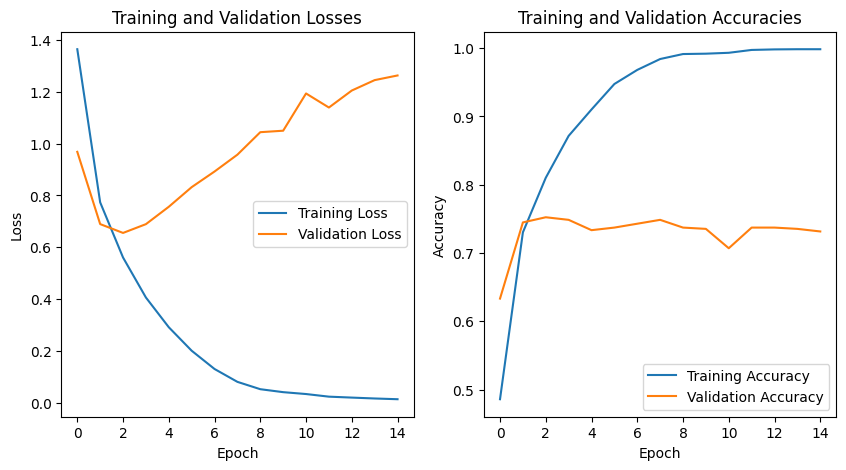

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Initialize lists to store loss and accuracy values
train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []

# Train
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))  # Set position to 'right'
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # Calculate accuracy
    train_accuracy = accuracy_score(list_label, list_hyp)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))  # Set position to 'right'
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Calculate accuracy
    valid_accuracy = accuracy_score(list_label, list_hyp)
    valid_accuracies.append(valid_accuracy)
    
    # Append losses
    train_losses.append(total_train_loss / len(train_loader))
    valid_losses.append(total_loss / len(valid_loader))

    
# Plotting
plt.figure(figsize=(10, 5))

# Plotting training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

# Save the plot as an image
plt.savefig('/kaggle/working/accuracy_loss_curves.png')

# Show plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Initialize lists to store loss and accuracy values
train_losses, valid_losses, train_accuracies, valid_accuracies = [], [], [], []

# Train
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # Calculate accuracy
    train_accuracy = accuracy_score(list_label, list_hyp)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Calculate accuracy
    valid_accuracy = accuracy_score(list_label, list_hyp)
    valid_accuracies.append(valid_accuracy)
    
    # Append losses
    train_losses.append(total_train_loss / len(train_loader))
    valid_losses.append(total_loss / len(valid_loader))
    
# Plotting
plt.figure(figsize=(10, 5))

# Plotting training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

# Save the plot as an image
plt.savefig('/kaggle/working/accuracy_loss_curves.png')

# Show plot
plt.show()

  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) TRAIN LOSS:0.0135 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.34it/s]


(Epoch 1) TRAIN LOSS:0.0135 ACC:0.9974 F1:0.9977 REC:0.9976 PRE:0.9978 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.0515 ACC:0.6250 F1:0.5787 REC:0.6388 PRE:0.5755:   6%|▌         | 1/17 [00:00<00:12,  1.32it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5313 ACC:0.5781 F1:0.4716 REC:0.4984 PRE:0.4870:   6%|▌         | 1/17 [00

(Epoch 1) VALID LOSS:1.2831 ACC:0.7372 F1:0.7485 REC:0.7515 PRE:0.7564


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.0158 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 2) TRAIN LOSS:0.0158 ACC:0.9966 F1:0.9968 REC:0.9968 PRE:0.9969 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.8243 ACC:0.7188 F1:0.6644 REC:0.7232 PRE:0.6655:   6%|▌         | 1/17 [00:00<00:12,  1.31it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2727 ACC:0.6250 F1:0.5036 REC:0.5178 PRE:0.5015:   6%|▌         | 1/17 [00

(Epoch 2) VALID LOSS:1.2519 ACC:0.7429 F1:0.7481 REC:0.7512 PRE:0.7495


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.0191 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.32it/s]


(Epoch 3) TRAIN LOSS:0.0191 ACC:0.9953 F1:0.9960 REC:0.9960 PRE:0.9960 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.0085 ACC:0.6875 F1:0.6312 REC:0.7010 PRE:0.6400:   6%|▌         | 1/17 [00:00<00:11,  1.37it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.4875 ACC:0.6094 F1:0.4888 REC:0.5085 PRE:0.4856:   6%|▌         | 1/17 [00

(Epoch 3) VALID LOSS:1.2647 ACC:0.7467 F1:0.7583 REC:0.7600 PRE:0.7576


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.0131 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 4) TRAIN LOSS:0.0131 ACC:0.9977 F1:0.9980 REC:0.9981 PRE:0.9980 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.9603 ACC:0.6875 F1:0.6324 REC:0.7010 PRE:0.6410:   6%|▌         | 1/17 [00:00<00:13,  1.16it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.4842 ACC:0.6094 F1:0.4915 REC:0.5085 PRE:0.4936:   6%|▌         | 1/17 [00

(Epoch 4) VALID LOSS:1.2984 ACC:0.7240 F1:0.7370 REC:0.7340 PRE:0.7414


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.0100 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 5) TRAIN LOSS:0.0100 ACC:0.9979 F1:0.9983 REC:0.9982 PRE:0.9983 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.0742 ACC:0.6250 F1:0.5787 REC:0.6388 PRE:0.5755:   6%|▌         | 1/17 [00:00<00:11,  1.40it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.6298 ACC:0.5781 F1:0.4744 REC:0.4975 PRE:0.4848:   6%|▌         | 1/17 [00

(Epoch 5) VALID LOSS:1.3304 ACC:0.7278 F1:0.7406 REC:0.7430 PRE:0.7414


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 6) TRAIN LOSS:0.0104 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 6) TRAIN LOSS:0.0104 ACC:0.9977 F1:0.9980 REC:0.9980 PRE:0.9980 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.8374 ACC:0.6875 F1:0.6669 REC:0.7188 PRE:0.6500:   6%|▌         | 1/17 [00:00<00:11,  1.41it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5218 ACC:0.6094 F1:0.5090 REC:0.5335 PRE:0.5069:   6%|▌         | 1/17 [00

(Epoch 6) VALID LOSS:1.2989 ACC:0.7391 F1:0.7518 REC:0.7510 PRE:0.7549


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 7) TRAIN LOSS:0.0103 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.31it/s]


(Epoch 7) TRAIN LOSS:0.0103 ACC:0.9979 F1:0.9981 REC:0.9982 PRE:0.9979 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:1.7964 ACC:0.7500 F1:0.7339 REC:0.7632 PRE:0.7321:   6%|▌         | 1/17 [00:00<00:11,  1.45it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3095 ACC:0.6406 F1:0.5302 REC:0.5377 PRE:0.5332:   6%|▌         | 1/17 [00

(Epoch 7) VALID LOSS:1.3079 ACC:0.7467 F1:0.7594 REC:0.7527 PRE:0.7694


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 8) TRAIN LOSS:0.0149 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 8) TRAIN LOSS:0.0149 ACC:0.9956 F1:0.9957 REC:0.9956 PRE:0.9959 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.1563 ACC:0.6562 F1:0.6333 REC:0.6788 PRE:0.6255:   6%|▌         | 1/17 [00:00<00:11,  1.34it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5504 ACC:0.5938 F1:0.4952 REC:0.5184 PRE:0.5037:   6%|▌         | 1/17 [00

(Epoch 8) VALID LOSS:1.2945 ACC:0.7505 F1:0.7644 REC:0.7609 PRE:0.7692


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 9) TRAIN LOSS:0.0069 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.33it/s]


(Epoch 9) TRAIN LOSS:0.0069 ACC:0.9992 F1:0.9992 REC:0.9993 PRE:0.9991 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.2190 ACC:0.6875 F1:0.6566 REC:0.7010 PRE:0.6510:   6%|▌         | 1/17 [00:00<00:11,  1.42it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5904 ACC:0.5938 F1:0.4862 REC:0.5059 PRE:0.4848:   6%|▌         | 1/17 [00

(Epoch 9) VALID LOSS:1.3374 ACC:0.7448 F1:0.7548 REC:0.7587 PRE:0.7536


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 10) TRAIN LOSS:0.0135 LR:0.00000500: 100%|██████████| 120/120 [00:22<00:00,  5.27it/s]


(Epoch 10) TRAIN LOSS:0.0135 ACC:0.9961 F1:0.9966 REC:0.9966 PRE:0.9966 LR:0.00000500


  0%|          | 0/17 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:2.3271 ACC:0.6250 F1:0.6139 REC:0.6606 PRE:0.6067:   6%|▌         | 1/17 [00:00<00:11,  1.42it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.6573 ACC:0.5625 F1:0.4696 REC:0.4883 PRE:0.4661:   6%|▌         | 1/17 [00

(Epoch 10) VALID LOSS:1.4381 ACC:0.7221 F1:0.7336 REC:0.7422 PRE:0.7311


  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 11) TRAIN LOSS:0.0072 LR:0.00000500:  48%|████▊     | 58/120 [00:11<00:10,  5.68it/s]

In [ ]:
def emotion_detection_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluate on test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('/kaggle/working/pred.txt', index=False)

print(df)

# Calculate test metrics
metrics = emotion_detection_metrics_fn(list_hyp, list_label)
print("TEST Metrics:", metrics_to_string(metrics))

# Calculate confusion matrix
cm = confusion_matrix(list_label, list_hyp)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=i2w.values(), yticklabels=i2w.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Save the plot as an image
plt.savefig('/kaggle/working/confusion_matrix2.png')

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Evaluate on test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(train_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('/kaggle/working/pred.txt', index=False)

print(df)

# Calculate test metrics
metrics = emotion_detection_metrics_fn(list_hyp, list_label)
print("TEST Metrics:", metrics_to_string(metrics))

# Print classification report
print("Classification Report:")
print(classification_report(list_label, list_hyp, target_names=i2w.values()))

In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

# Test fine-tuned model on sample sentences

In [ ]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
User_input = input('Masukkan Kalimat')
text = User_input
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

In [ ]:
import os

# Simpan model, konfigurasi, dan optimizer setelah pelatihan
model_checkpoint_path = '/kaggle/working/fine_tuned_model_checkpoint10.pt'
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': config,
            }, model_checkpoint_path)

# Simpan tokenizer
tokenizer_directory = '/kaggle/working/tokenizer_directory11'
os.makedirs(tokenizer_directory, exist_ok=True)
tokenizer.save_pretrained(tokenizer_directory)

In [ ]:
# Fungsi untuk memuat model dan tokenizer
def load_model_and_tokenizer(model_path, tokenizer_path):
    checkpoint = torch.load(model_path)
    model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=checkpoint['config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    return model, tokenizer

# Fungsi untuk memuat dataset
def load_datasets(train_path, valid_path, test_path):
    train_dataset = pd.read_csv(train_path)
    valid_dataset = pd.read_csv(valid_path)
    test_dataset = pd.read_csv(test_path)
    return train_dataset, valid_dataset, test_dataset

In [ ]:
def predict_sentence(model, tokenizer, sentence, i2w):
    subwords = tokenizer.encode(sentence)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    logits = model(subwords)[0]
    probabilities = F.softmax(logits, dim=-1).squeeze().tolist()

    predictions = [(i2w[i], prob * 100) for i, prob in enumerate(probabilities)]

    return predictions

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer('/kaggle/working/fine_tuned_model_checkpoint4.pt', '/kaggle/working/tokenizer_directory4')

while True:
    # Ask user to input a sentence
    user_input = input('Masukkan kalimat yang ingin diprediksi (ketik "exit" untuk keluar): ')
    
    # Exit if user types 'exit'
    if user_input.lower() == 'exit':
        break

    # Predict the input sentence
    predictions = predict_sentence(model, tokenizer, user_input, i2w)
    for label, confidence in predictions:
        print(f'{label}: {confidence:.2f}%')

In [ ]:
model_checkpoint_path = 'fine_tuned_model_checkpoint.pt'
checkpoint = torch.load(model_checkpoint_path)

# Load tokenizer
tokenizer_directory = '/kaggle/working/tokenizer_directory'
tokenizer = BertTokenizer.from_pretrained(tokenizer_directory)

# Load model configuration
config = checkpoint['config']

# Initialize model
model = BertForSequenceClassification(config)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)  # Set strict=False to ignore missing keys
model.eval()